In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy as sc

In [2]:
""" Read the data and return it as an array (n, m) where n is the nbr of channels (time, wavelength(s), temperature...) 
and m the nbr of datapoints from a python readout of the WLM. Check that each mesure has the amount of channel fixed by 
the first line and that there is no reset of the time (else compensate for it) """
def ReadDataPythonReadOut(path_name):
    with open(path_name, 'r') as file:
        Data = file.read()

    Data = Data.split("\n")

    # Initialize
    res = np.zeros((len(Data[0].split(" ")), len(Data)))
    try:
        res[:, 0] = np.array(Data[0].split(" "), dtype=float)    
    except: # If error in reading (not everything is measured), return nothing
        print("Error initialization")
        return res
    
    time_offset = 0 # If time reinitialized, keep time increasing

    # Import the data line by line
    for i in range(1, len(Data)):
        try:
            res[:, i] = np.array(Data[i].split(" "), dtype=float)

            # Fix jumping time
            res[0, i] = res[0, i] + time_offset
            if res[0, i] < res[0, i-1]: # Time is not increasing
                time_offset = res[0, i-1] + np.mean(res[0, 1:i]-res[0, :i-1]) # Time reset -> offset = previous time + mean DeltaT
                res[0, i] = time_offset
                print("Time problem line "+str(i))

        except: # If error in reading (not everything is measured), put -1 for the time
            print("Error line "+str(i))
            res[0, i] = -1
    return res

In [3]:
path_name = r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\DataWeekend_2025_09_26_Lambda_P_T_temp1.txt"#r"Z:\Users\Remy\PID_Laser\PythonReadOut\SavedData\NoPID\DataWeekend_2025_09_26_Lambda_P_T_temp1.txt"
cutoff_std_lambda = 10 # Distance from mean above which data is absurd
T, Lambda, Pressure, Temperature = ReadDataPythonReadOut(path_name)
T, Lambda, Pressure, Temperature = T[T!=-1], Lambda[T!=-1], Pressure[T!=-1], Temperature[T!=-1] # Remove lines where every channel was not saved
Absurd_Lambda = np.abs(Lambda-np.mean(Lambda))<cutoff_std_lambda # Remove the data points where the wavelength distance from the mean is bigger than cutoff_std_lambda
T_clean, Lambda_clean, Pressure_clean, Temperature_clean = T[Absurd_Lambda], Lambda[Absurd_Lambda], Pressure[Absurd_Lambda], Temperature[Absurd_Lambda]

Time problem line 2055
Error line 1245055


### Compute averaged signals

In [7]:
width_mean = int(1e1)
if len(Lambda_clean)%width_mean == 0: # No need to cut Lambda
    T_Mean = T_clean[::width_mean]
    Mean_Lambda = np.mean(np.reshape(Lambda_clean, (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    Temperature_mean = np.mean(np.reshape(Temperature_clean, (len(Temperature_clean)//width_mean, width_mean)), axis=1)
    Pressure_mean = np.mean(np.reshape(Pressure_clean, (len(Pressure_clean)//width_mean, width_mean)), axis=1)
else:
    T_Mean = T_clean[:-(len(Lambda_clean)%width_mean):width_mean]
    Mean_Lambda = np.mean(np.reshape(Lambda_clean[:-(len(Lambda_clean)%width_mean)], (len(Lambda_clean)//width_mean, width_mean)), axis=1)
    Temperature_mean = np.mean(np.reshape(Temperature_clean[:-(len(Temperature_clean)%width_mean)], (len(Temperature_clean)//width_mean, width_mean)), axis=1)
    Pressure_mean = np.mean(np.reshape(Pressure_clean[:-(len(Pressure_clean)%width_mean)], (len(Pressure_clean)//width_mean, width_mean)), axis=1)

### Compute FFT

In [13]:
FT_Lambda_mean = np.fft.fft(Mean_Lambda) # In nm.s
fs_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_mean)

FT_temperature_mean = np.fft.fft(Temperature_mean) # In °C
fs_temperature_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_temperature_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_temperature_mean)

FT_pressure_mean = np.fft.fft(Pressure_mean) # In °C
fs_pressure_mean = 1e3*(len(T_Mean)-1)/T_Mean[-1] # In Hz
Freq_pressure_mean = np.fft.fftfreq(len(T_Mean), d=1/fs_pressure_mean)

In [71]:
def update(val):
    alpha_temperature = slider_alpha_temperature.val
    alpha_pressure = slider_alpha_pressure.val
    pltFFT_Temperature.set_ydata(np.abs(alpha_temperature*FT_temperature_mean)**2)
    pltFFT_Pressure.set_ydata(np.abs(alpha_pressure*FT_pressure_mean)**2)
    fig.canvas.draw_idle()


0

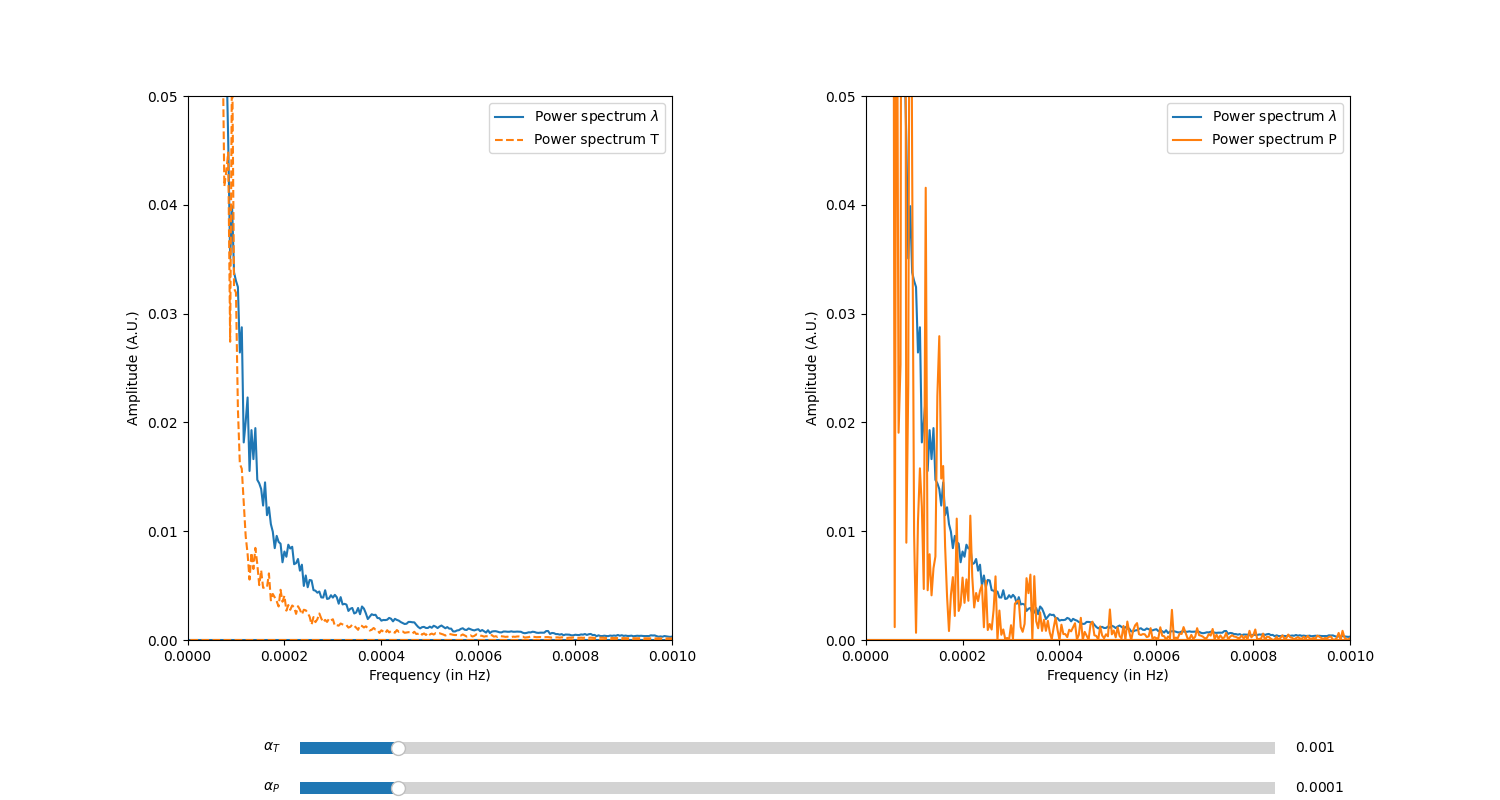

In [94]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
fig.subplots_adjust(wspace=0.4, bottom=0.2)
axe_alpha_temperature = fig.add_axes([0.2, 0.05, 0.65, 0.03])
axe_alpha_pressure = fig.add_axes([0.2, 0, 0.65, 0.03])
alpha_temperature, alpha_pressure = 1e-3, 1e-4 # Initial values for the alpha's
slider_alpha_temperature = Slider(axe_alpha_temperature, label=r"$\alpha_T$", valmin=0, valmax=1e-2, valinit=alpha_temperature)
slider_alpha_pressure = Slider(axe_alpha_pressure, label=r"$\alpha_P$", valmin=0, valmax=1e-3, valinit=alpha_pressure)
axes[0].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label=r"Power spectrum $\lambda$")
axes[1].plot(Freq_mean, np.abs(FT_Lambda_mean)**2, label=r"Power spectrum $\lambda$")

pltFFT_Temperature, = axes[0].plot(Freq_temperature_mean, np.abs(alpha_temperature*FT_temperature_mean)**2, label="Power spectrum T", linestyle="--")
pltFFT_Pressure, = axes[1].plot(Freq_pressure_mean, np.abs(alpha_pressure*FT_pressure_mean)**2, label="Power spectrum P")

axes[0].set_xlim(0, 1e-3)
axes[1].set_xlim(0, 1e-3)
axes[0].set_ylim(0, 5e-2)
axes[1].set_ylim(0, 5e-2)
axes[0].set_xlabel("Frequency (in Hz)")
axes[0].set_ylabel("Amplitude (A.U.)")
axes[1].set_xlabel("Frequency (in Hz)")
axes[1].set_ylabel("Amplitude (A.U.)")
axes[0].legend()
axes[1].legend()

slider_alpha_temperature.on_changed(update)
slider_alpha_pressure.on_changed(update)